In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [1]:
import pandas as pd
from datasets import load_dataset, load_metric
from tqdm import tqdm
import torch
# Importing dependencies from transformers
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
!pip install evaluate
import evaluate
from transformers import DataCollatorForSeq2Seq

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Load data

Link: https://huggingface.co/datasets/samsum

In [4]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])

Found cached dataset samsum (C:/Users/admin/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


# Evaluating PEGASUS on SAMSum

In [9]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [68]:
label_summ = dataset_samsum['test']['summary']
model_prediction_before_tunning = []

In [69]:
# Load model 
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")
# Load tokenizer 
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")

In [70]:
for i in tqdm(range(len(dataset_samsum["test"]["dialogue"]))):
  # Create tokens - number representation of our text
  tokens = tokenizer(dataset_samsum["test"]["dialogue"][i], truncation=True, padding="longest", return_tensors="pt")
  # Summarize 
  summary = model.generate(**tokens)
  # Decode summary
  s = tokenizer.decode(summary[0])
  s = s.replace("<pad>", '')
  s = s.replace("</s>", '')
  model_prediction_before_tunning.append(s)

  0%|                                                                                          | 0/819 [00:00<?, ?it/s]C:\Users\admin\anaconda3\lib\site-packages\transformers\generation\utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 256 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [2:24:00<00:00, 10.55s/it]


In [71]:
rouge = evaluate.load('rouge')

In [72]:
results = rouge.compute(predictions=model_prediction_before_tunning, references=label_summ)

In [75]:
results

{'rouge1': 0.25750999089311444,
 'rouge2': 0.06254491197920076,
 'rougeL': 0.20096293390302267,
 'rougeLsum': 0.20068649322131393}

In [73]:
results_df = pd.DataFrame(results.values(), index=results.keys())

In [74]:
results_df.to_pickle("Pegasus_before_tune.pkl")

In [ ]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

In [23]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=3, warmup_steps=128,
    per_device_train_batch_size=4, per_device_eval_batch_size=4,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=128, save_steps=1e6,
    gradient_accumulation_steps=16
) 

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [24]:
trainer = Trainer(model=model, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

In [25]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14732
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 16
  Total optimization steps = 690
  Number of trainable parameters = 568699904


Step,Training Loss,Validation Loss
128,1.677900,1.519297
256,1.535400,1.444488
384,1.524800,1.422122
512,1.446200,1.409737
640,1.468000,1.404562


The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 818
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, summary, id. If dialogue, summary, id are not expected by `PegasusForConditionalGeneration.forward`,  you can sa

TrainOutput(global_step=690, training_loss=1.6703253303748975, metrics={'train_runtime': 85633.509, 'train_samples_per_second': 0.516, 'train_steps_per_second': 0.008, 'total_flos': 3.020691246494515e+16, 'train_loss': 1.6703253303748975, 'epoch': 3.0})

In [27]:
## Save model
model.save_pretrained("pegasus-samsum-model")

Configuration saved in pegasus-samsum-model\config.json
Model weights saved in pegasus-samsum-model\pytorch_model.bin


In [28]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

tokenizer config file saved in tokenizer\tokenizer_config.json
Special tokens file saved in tokenizer\special_tokens_map.json


('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\spiece.model',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

# Test

In [5]:
dataset_samsum = load_dataset("samsum")

Found cached dataset samsum (C:/Users/admin/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# Load model 
model = PegasusForConditionalGeneration.from_pretrained("pegasus-samsum-model")
# Load tokenizer 
tokenizer = PegasusTokenizer.from_pretrained("tokenizer")

In [10]:
dataset_samsum["test"]

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 819
})

In [11]:
lable_summarization = dataset_samsum["test"]["summary"]
predicted_summary = []

In [14]:
for i in tqdm(range(len(dataset_samsum["test"]["dialogue"]))):
  # Create tokens - number representation of our text
  tokens = tokenizer(dataset_samsum["test"]["dialogue"][i], truncation=True, padding="longest", return_tensors="pt")
  # Summarize 
  summary = model.generate(**tokens)
  # Decode summary
  s = tokenizer.decode(summary[0])
  s = s.replace("<pad>", '')
  s = s.replace("</s>", '')
  predicted_summary.append(s)

  0%|                                                                                          | 0/819 [00:00<?, ?it/s]C:\Users\admin\anaconda3\lib\site-packages\transformers\generation\utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 256 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 819/819 [54:23<00:00,  3.98s/it]


In [16]:
rouge = evaluate.load('rouge')

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     -------------------------------------- 81.4/81.4 kB 912.7 kB/s eta 0:00:00


In [58]:
results = rouge.compute(predictions=predicted_summary, references=lable_summarization)

In [65]:
df = pd.DataFrame(predicted_summary, columns=["Model Prediction"])

In [66]:
df["Real Summary"] = lable_summarization

In [67]:
df.to_pickle("Pegasus_Prediction.pkl")

In [59]:
results

{'rouge1': 0.49079108330397236,
 'rouge2': 0.25405230041484256,
 'rougeL': 0.4115577390570213,
 'rougeLsum': 0.41161866524535745}

In [60]:
results_df = pd.DataFrame(results.values(), index=results.keys())

In [62]:
results_df

,0
rouge1,0.490791
rouge2,0.254052
rougeL,0.411558
rougeLsum,0.411619


In [64]:
results_df.to_pickle("Pegasuspre_trained_results.pkl")

# plot Pegasus Results Before and After Tunning

In [1]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [6]:
pegasus_rouge_before_tunning = {'rouge1': 0.25750999089311444,
 'rouge2': 0.06254491197920076,
 'rougeL': 0.20096293390302267,
 'rougeLsum': 0.20068649322131393}

In [7]:
pegasus_rouge_after_tunning = {'rouge1': 0.49079108330397236,
 'rouge2': 0.25405230041484256,
 'rougeL': 0.4115577390570213,
 'rougeLsum': 0.41161866524535745}

In [11]:
X_axis = ['Pegasus Before Tunning','Pegasus After Tunning']
rouge_1_y_axis = [pegasus_rouge_before_tunning['rouge1'], pegasus_rouge_after_tunning['rouge1']]
rouge_2_y_axis = [pegasus_rouge_before_tunning['rouge2'], pegasus_rouge_after_tunning['rouge2']]
rouge_l_y_axis = [pegasus_rouge_before_tunning['rougeL'], pegasus_rouge_after_tunning['rougeL']]
rouge_l_sum_y_axis = [pegasus_rouge_before_tunning['rougeLsum'], pegasus_rouge_after_tunning['rougeLsum']]

In [12]:
# Plot The Result Using Plotly
px.bar(x=X_axis, y=rouge_1_y_axis, color=X_axis, title="Rouge 1").update_layout(
    xaxis_title="Pagasus Summarization Model", 
    yaxis_title="Rouge"
)

In [14]:
# Plot The Result Using Plotly
px.bar(x=X_axis, y=rouge_2_y_axis, color=X_axis, title="Rouge 2").update_layout(
    xaxis_title="Pagasus Summarization Model", 
    yaxis_title="Rouge"
)

In [15]:
# Plot The Result Using Plotly
px.bar(x=X_axis, y=rouge_l_y_axis, color=X_axis, title="Rouge L").update_layout(
    xaxis_title="Pagasus Summarization Model", 
    yaxis_title="Rouge"
)

In [16]:
# Plot The Result Using Plotly
px.bar(x=X_axis, y=rouge_l_sum_y_axis, color=X_axis, title="Rouge L Sum").update_layout(
    xaxis_title="Pagasus Summarization Model", 
    yaxis_title="Rouge"
)

In [18]:
# plot val loss and train loss while training
steps = ['128', '256', '384', '512', '640']
train_loss = [1.677900, 1.535400, 1.524800, 1.446200, 1.468000]
val_loss = [1.519297, 1.444488, 1.422122, 1.409737, 1.404562]

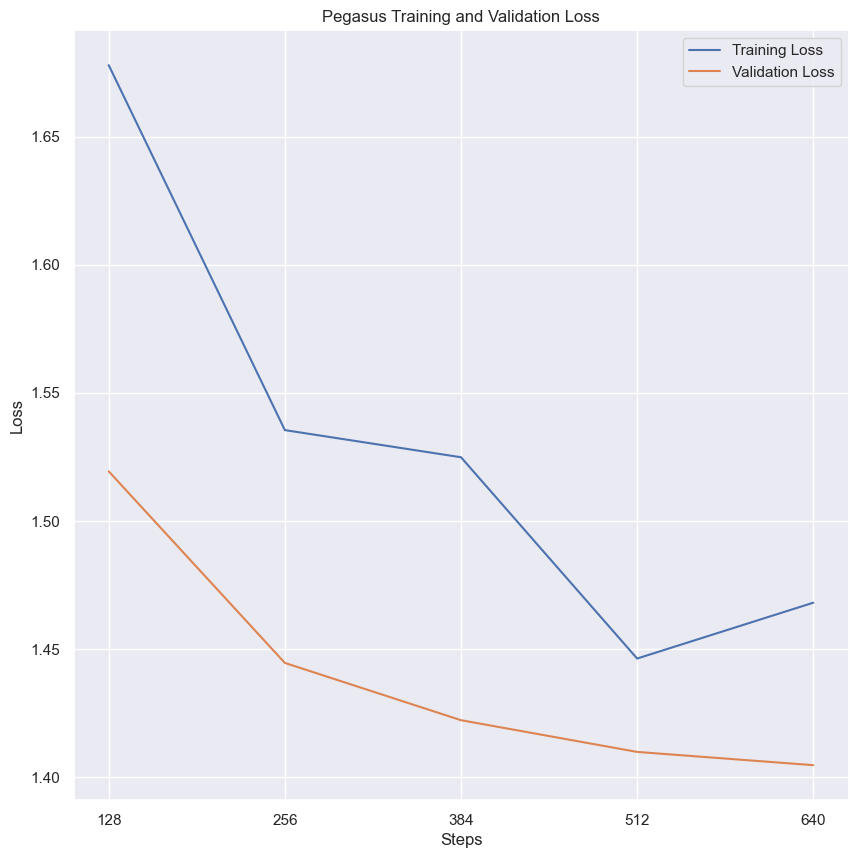

In [28]:
# Plot and label the training and validation loss values
plt.figure(figsize=(10, 10))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Pegasus Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()